In [1]:
import copy

import prody
from rdkit import Chem
from rdkit.Chem import Draw
from prody.proteins.functions import showProtein, view3D

from rgroup import rep2D, draw3D, merge_R_group, fix_receptor, optimise_in_receptor 

<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.


In [2]:
# load the complex with the ligand
sys = prody.parsePDB('5NEV.pdb1')
rec = sys.select('not (nucleic or hetatm) and not water')
mol = sys.select('resname 72L')

prody.writePDB('rec.pdb', rec)
# prody.writePDB('lig.pdb', mol)

@> 4485 atoms and 1 coordinate set(s) were parsed in 0.04s.


'rec.pdb'

In [3]:
!wget 'https://models.rcsb.org/v1/5nev/ligand?auth_seq_id=301&label_asym_id=E&encoding=sdf&filename=5nev_E_72L.sdf' -O lig.sdf
!obabel lig.sdf -O ligh.sdf -h -p 7
# ^manually modify the files if need be

--2021-09-13 13:25:37--  https://models.rcsb.org/v1/5nev/ligand?auth_seq_id=301&label_asym_id=E&encoding=sdf&filename=5nev_E_72L.sdf
SSL_INIT
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving models.rcsb.org (models.rcsb.org)... 128.6.159.81
Connecting to models.rcsb.org (models.rcsb.org)|128.6.159.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘lig.sdf’

lig.sdf                 [ <=>                ]   3.66K  --.-KB/s    in 0s      

2021-09-13 13:25:38 (41.6 MB/s) - ‘lig.sdf’ saved [3750]

*** Open Babel Warning  in DoTransformations
  Both -p and -h options are set. All implicit hydrogens (-h) will be added without considering pH.

1 molecule converted


In [4]:
# load the ligand
# rdkit doesn't do a good job with protonation, 
#init_mol = Chem.MolFromPDBFile('lig.pdb', removeHs=False)
#init_mol = Chem.AddHs(init_mol, addCoords=True)

init_mol = Chem.SDMolSupplier('ligh.sdf', removeHs=False)[0]

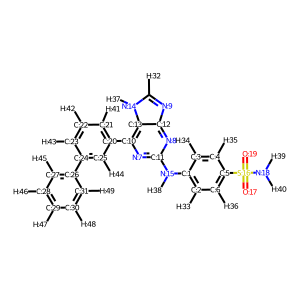

In [5]:
# select the atom to be replaced with the R group
Draw.MolToImage(rep2D(init_mol))

In [6]:
# load the R group
R_group = Chem.MolFromMolFile('data/rgroups/molecules/alcohols/propane-1_2_3-triol-r.mol', removeHs=False)
draw3D(R_group)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [7]:
rmol = merge_R_group(init_mol, R_group, 47)
rmol.draw3D()

Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f6a8ef309a0> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f6a8ef30d60>


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

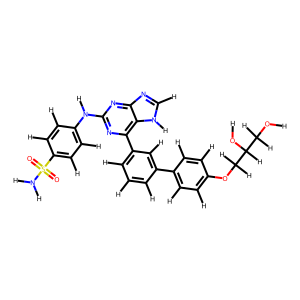

In [8]:
Draw.MolToImage(rep2D(rmol, idx=False))

In [9]:
toxicity = rmol.toxicity()
toxicity

,MW,HBA,HBD,LogP,Pass_Ro5,has_pains,has_unwanted_subs
0,532.152889,9,5,2.8099,True,False,False


In [10]:
# visualise the template
# draw3D(rmol.template)

In [11]:
rmol.draw3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [12]:
rmol.generate_conformers(num_conf=30, minimum_conf_rms=0.5)

removed 3 duplicated conformations


In [13]:
rmol.draw3Dconfs()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [14]:
rmol.GetNumConformers()

28

In [15]:
# fix the receptor file 
fix_receptor("rec.pdb", "rec_h.pdb")
# load back into prody
rec_fix = prody.parsePDB("rec_h.pdb")

@> 8925 atoms and 1 coordinate set(s) were parsed in 0.05s.


In [16]:
# filter by the protein clashes
view = view3D(rec_fix)
rmol.draw3Dconfs(view)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [17]:
import py3Dmol
view = py3Dmol.view(width=300, height=300, viewergrid=(1, 1))

for conf in rmol.GetConformers():
    mb = Chem.MolToMolBlock(rmol, confId=conf.GetId())
    view.addModel(mb, "lig")

view.setStyle({'stick':{}})
view.zoomTo()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [18]:
rmol.removeConfsClashingWithProdyProt(rec_fix)

Clash with the protein. Removing conformer id: 27
Clash with the protein. Removing conformer id: 24
Clash with the protein. Removing conformer id: 19
Clash with the protein. Removing conformer id: 16
Clash with the protein. Removing conformer id: 14
Clash with the protein. Removing conformer id: 9
Clash with the protein. Removing conformer id: 8
Clash with the protein. Removing conformer id: 0


In [19]:
view = view3D(rec_fix)
#rmol.draw3Dconfs(view)

In [20]:
 final_mol, energies = optimise_in_receptor(rmol, "rec_h.pdb", "openff", False)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. RDMol name: 72LUndefined chiral centers are:
 - Atom C (index 54)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 5)

Optimising conformer: 100%|█████████████████████| 20/20 [00:02<00:00,  6.86it/s]


In [21]:
type(final_mol)
final_mol.draw3Dconfs()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [22]:
final_mol.to_file("optimised_corrds.pdb")

In [23]:
print(energies)

[41806.90950645315, 41815.663091539194, 41808.22030353728, 41806.44269837476, 41802.095781548756, 41802.47669694072, 41803.58583293499, 41808.86263145315, 41820.80544933078, 41808.88877270554, 41812.21618068834, 41824.49136591778, 41806.920709847036, 41818.09422801147, 41826.283908938814, 41799.02605162524, 41802.76051625239, 41816.839447896746, 41804.85928537285, 41809.6394000956]
